In [1]:
from lyricsgenius import Genius
import pandas as pd
import os
import re
import requests
import sys
import os
import pandas as pd
import numpy as np
import tiktoken
from openai import AzureOpenAI
from bs4 import BeautifulSoup
import re
from langchain.text_splitter import RecursiveCharacterTextSplitter 
import urllib.request
import json
import pickle
import h5py
import csv
from sklearn.metrics.pairwise import cosine_similarity
import os
from bs4 import BeautifulSoup
from lyricsgenius import Genius
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [15]:
df_viper = pd.read_csv("viper_songs.csv", encoding='utf-8').head(30)
print(len(df_viper))

30


In [5]:
api_key = os.getenv('DIM_RED_API_KEY')
endpoint =  os.getenv('DIM_RED_ENDPOINT')
client = AzureOpenAI(
    api_key = api_key,  
    api_version = "2024-02-01",
    azure_endpoint = endpoint
)
# def get_embedding(text, model="text-embedding-ada-002"): # model = "deployment_name"
#     return client.embeddings.create(input = text, model=model).data[0].embedding

In [17]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=3000, chunk_overlap=100)

# Function to split lyrics
def split_lyrics(lyrics):
    split_lyrics = text_splitter.split_text(lyrics)
    return split_lyrics

df_viper['split_lyrics'] = df_viper['Lyrics'].apply(split_lyrics)



In [3]:
def generate_embeddings(texts, model="text-embedding-ada-002"):
    embeddings = client.embeddings.create(input=texts, model=model)
    return [embedding.embedding for embedding in embeddings.data]

# all_chunks = [chunk for chunks in df_viper["split_lyrics"] for chunk in chunks]
# all_embeddings = generate_embeddings(all_chunks)

# # Reassemble the embeddings back to the original structure
# embedding_iter = iter(all_embeddings)
# df_viper['ada_v2'] = df_viper["split_lyrics"].apply(lambda chunks: [next(embedding_iter) for _ in chunks])

# # Verify the structure
# print(df_viper.head())

In [25]:
df_viper.to_csv("df_viper_reduced.csv", encoding='utf-8' )

In [13]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import plotly.express as px
import json
# Load your DataFrame and convert embeddings to a NumPy array
df_viper = pd.read_csv("df_viper_reduced.csv").head(30)  # Adjust the file and row limit as needed
df_viper['ada_v2'] = df_viper['ada_v2'].apply(json.loads)

# Assuming the embeddings are lists inside the 'ada_v2' column
words = ['happy', 'sad' ,'joyful', 'beautiful']
# for element in df_viper['ada_v2']:
#     embeddings_listt.append(np.array(element[0]))
np_embeddings_listt = np.array(generate_embeddings(words))
num_samples = len(words)

# np_embeddings_listt = np.array(embeddings_listt)
# num_samples = np_embeddings_listt.shape[0]

# Perform t-SNE with 3 components for 3D plotting
tsne = TSNE(n_components=3, random_state=15, perplexity=(num_samples - 1))
tsne_results = tsne.fit_transform(np_embeddings_listt)

# # Add the t-SNE results to the DataFrame
# df_viper['tsne-3d-one'] = tsne_results[:, 0]
# df_viper['tsne-3d-two'] = tsne_results[:, 1]
# df_viper['tsne-3d-three'] = tsne_results[:, 2]

# Create the interactive 3D scatter plot
tsne_df = pd.DataFrame(tsne_results, columns=['tsne-3d-one', 'tsne-3d-two', 'tsne-3d-three'])
tsne_df['Title'] = words[:len(tsne_df)]  # Add titles for labeling

# Create the interactive 3D scatter plot
fig = px.scatter_3d(
    tsne_df,
    x='tsne-3d-one',
    y='tsne-3d-two',
    z='tsne-3d-three',
    text='Title',
    title='t-SNE Visualization of Song Lyrics Embeddings (3D)'
)


fig.write_html("interactive_3d_plot.html")

# Open the HTML file in the default web browser
import webbrowser
webbrowser.open("interactive_3d_plot.html")

True

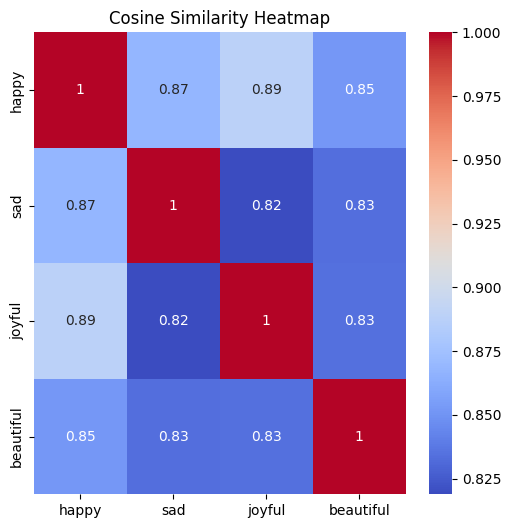

In [14]:
import seaborn as sns
cosine_sim_matrix = cosine_similarity(np_embeddings_listt)

# Create a DataFrame for the cosine similarity matrix
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=words, columns=words)

# Plot the heatmap
plt.figure(figsize=(6,6))
sns.heatmap(cosine_sim_df, annot=True, cmap='coolwarm')
plt.title('Cosine Similarity Heatmap')
plt.show()

In [34]:
df_fictional_lyrics = pd.read_csv("fictional_lyrics.csv", encoding = 'utf-8')
fict_listt = []
for i in df_fictional_lyrics["Lyrics"]:
    fict_listt.append(i)
all_embeddings = generate_embeddings(fict_listt)

In [18]:
import gensim.downloader as api
from gensim.models import KeyedVectors

def load_glove_model():
    """Load pre-trained GloVe model."""
    # Load the pre-trained model
    model = api.load("glove-wiki-gigaword-50")
    return model

def find_similar_words(model, target_word, top_n=20):
    """Find the top N most similar words to the target word."""
    # Check if the target word is in the model's vocabulary
    if target_word not in model:
        raise ValueError(f"The word '{target_word}' is not in the vocabulary.")
    
    # Find similar words
    similar_words = model.most_similar(target_word, topn=top_n)
    
    return similar_words

# Load GloVe model
model = load_glove_model()

# Define the target word
target_word = 'happy'

# Find similar words
similar_words = find_similar_words(model, target_word)

# Print the top 20 similar words
for word, score in similar_words:
    print(f"{word}: {score:.4f}")


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [37]:
df_fictional_lyrics["ada_v2"] = all_embeddings

In [45]:
# def get_avg_embedding(cat : str):
#     filtered_df = df_fictional_lyrics[df_fictional_lyrics['Category'].str.contains(cat, case=False, na=False)]
#     embeddings_arr = filtered_df["ada_v2"].tolist()
#     average_embedding = np.mean(np.array(embeddings_arr), axis=0)
#     return average_embedding
# cat_list = ["Violent", "Happy", "Breakup"]

# avg_embedding_dictt = {}
# for cat in cat_list:
#     avg_embedding_dictt[cat] = get_avg_embedding(cat)
# print(avg_embedding_dictt)
# Sample data: replace with your actual embeddings
# embeddings_listt = [np.array([...]), np.array([...]), ...]

# # Convert the list of embeddings to a NumPy array
# embeddings_array = np.array(embeddings_listt)

# # Calculate the average of the embeddings
# average_embedding = np.mean(embeddings_array, axis=0)

# # Print the result
# print("Average Embedding:", average_embedding)


{'Violent': array([-0.01336915, -0.00708778,  0.00527263, ..., -0.04036739,
       -0.0172088 , -0.00585619]), 'Happy': array([ 0.00771518, -0.01045196, -0.00085318, ..., -0.01821575,
        0.0015982 , -0.0262361 ]), 'Breakup': array([-0.00593296, -0.02383223, -0.00077208, ..., -0.00744729,
        0.00998273, -0.0234409 ])}


In [72]:
df_viper['similarities']  = df_viper.apply(
        lambda row: cosine_similarity( (np.array(row['ada_v2'][0]).reshape(1, -1) ) , avg_embedding_dictt["Happy"].reshape(1,-1))[0][0], axis=1
    )
res = (
        df_viper.sort_values("similarities", ascending=False)
        .head(30)
    )
display(res)
# print(type( (np.array(df_viper['ada_v2'][0]).reshape(1, -1) ) ))

,Unnamed: 0,Title,Lyrics,split_lyrics,ada_v2,tsne-3d-one,tsne-3d-two,tsne-3d-three,similarities
2,2,"Hey, Maybe One Day You’ll See Me Again","Hey, Maybe One Day You’ll See Me Again Lyrics[...","[""Hey, Maybe One Day You’ll See Me Again Lyric...","[[-0.031161179766058922, -0.025848453864455223...",65.036125,-11.502997,56.957436,0.809173
20,20,This Is How We Ride,This Is How We Ride Lyrics[Hook: G-Money]\n'Ca...,"[""This Is How We Ride Lyrics[Hook: G-Money]\n'...","[[0.009761896915733814, -0.014642844907939434,...",-39.786594,83.642754,94.103836,0.808742
28,28,Missing You,"issing You Lyrics[Chorus]\nNeeding you, missin...","[""issing You Lyrics[Chorus]\nNeeding you, miss...","[[-0.024850497022271156, -0.009974457323551178...",50.410515,53.902237,110.331055,0.805483
19,19,Ride Or Die,"ide Or Die Lyrics[Chorus]\nG's, sittin' on thr...","[""ide Or Die Lyrics[Chorus]\nG's, sittin' on t...","[[-0.013102496042847633, -0.014255515299737453...",-0.653986,-22.156570,136.780472,0.802481
13,13,Can’t Stop Me From Snowbirdin’,an’t Stop Me From Snowbirdin’ Lyrics[Chorus]\n...,"[""an’t Stop Me From Snowbirdin’ Lyrics[Chorus]...","[[-0.024812079966068268, -0.0285421684384346, ...",41.426029,-20.404554,-127.208908,0.802189
24,24,It’s On,"It’s On Lyrics[Chorus]\nSo, it is on\nAnd I'm ...","[""It’s On Lyrics[Chorus]\nSo, it is on\nAnd I'...","[[0.008633461780846119, -0.02045425958931446, ...",-2.038556,52.582146,-107.793274,0.799296
29,29,Choppers,"hoppers Lyrics[Chorus]\nSee, we turnin' these ...","[""hoppers Lyrics[Chorus]\nSee, we turnin' thes...","[[-0.007367268670350313, -0.016573047265410423...",-108.116356,-37.952431,23.574627,0.797765
9,9,I Gots To Ball,I Gots To Ball Lyrics[Chorus]\nI gots to ball\...,"[""I Gots To Ball Lyrics[Chorus]\nI gots to bal...","[[-0.024833237752318382, -0.011116274632513523...",-100.163063,7.352097,106.511719,0.795160
22,22,I Ball Or Die,Ball Or Die Lyrics[Chorus]\nI ball or die to ...,"[""Ball Or Die Lyrics[Chorus]\nI ball or die to...","[[-0.020482443273067474, -0.012641406618058681...",-124.080162,-5.321467,-60.133438,0.787942
21,21,Murda Urself My Man (Now I Finally Want Fame),Murda Urself My Man (Now I Finally Want Fame) ...,"[""Murda Urself My Man (Now I Finally Want Fame...","[[-0.019939731806516647, -0.019534451887011528...",-53.768459,-87.727257,77.445503,0.786322


In [71]:
violent_embedding = generate_embeddings("happy")
df_viper['similarities']  = df_viper.apply(
        lambda row: cosine_similarity( (np.array(row['ada_v2'][0]).reshape(1, -1) ) , np.array(violent_embedding).reshape(1,-1))[0][0], axis=1
    )
res = (
        df_viper.sort_values("similarities", ascending=False)
        .head(30)
    )
display(res)
# print(type( (np.array(df_viper['ada_v2'][0]).reshape(1, -1) ) ))

,Unnamed: 0,Title,Lyrics,split_lyrics,ada_v2,tsne-3d-one,tsne-3d-two,tsne-3d-three,similarities
29,29,Choppers,"hoppers Lyrics[Chorus]\nSee, we turnin' these ...","[""hoppers Lyrics[Chorus]\nSee, we turnin' thes...","[[-0.007367268670350313, -0.016573047265410423...",-108.116356,-37.952431,23.574627,0.736708
28,28,Missing You,"issing You Lyrics[Chorus]\nNeeding you, missin...","[""issing You Lyrics[Chorus]\nNeeding you, miss...","[[-0.024850497022271156, -0.009974457323551178...",50.410515,53.902237,110.331055,0.730776
19,19,Ride Or Die,"ide Or Die Lyrics[Chorus]\nG's, sittin' on thr...","[""ide Or Die Lyrics[Chorus]\nG's, sittin' on t...","[[-0.013102496042847633, -0.014255515299737453...",-0.653986,-22.156570,136.780472,0.726817
2,2,"Hey, Maybe One Day You’ll See Me Again","Hey, Maybe One Day You’ll See Me Again Lyrics[...","[""Hey, Maybe One Day You’ll See Me Again Lyric...","[[-0.031161179766058922, -0.025848453864455223...",65.036125,-11.502997,56.957436,0.724725
23,23,Thug Verses,Thug Verses Lyrics[Chorus]\n(esool m'I ekil em...,"[""Thug Verses Lyrics[Chorus]\n(esool m'I ekil ...","[[-0.013145813718438148, -0.014150803908705711...",-47.297211,124.995247,3.319168,0.721588
27,27,That Baller Out Your Best Side,hat Baller Out Your Best Side Lyrics[Hook]\nIt...,"[""hat Baller Out Your Best Side Lyrics[Hook]\n...","[[-0.02482777088880539, -0.00334363104775548, ...",-28.534313,1.440679,58.137123,0.721333
16,16,Leanin’ Low,"Leanin’ Low Lyrics[Chorus]\nI see you're gone,...",['Leanin’ Low Lyrics[Chorus]\nI see you\'re go...,"[[-0.011409787461161613, -0.015492310747504234...",45.573132,-90.273407,88.953453,0.721261
25,25,Respect My Hustle,espect My Hustle Lyrics[Chorus]\nThese marks g...,"[""espect My Hustle Lyrics[Chorus]\nThese marks...","[[-0.01974267140030861, -0.006264897994697094,...",35.908062,131.989700,51.303467,0.720729
1,1,You Wanna See Me Dead Cause Of My Hops,You Wanna See Me Dead Cause Of My Hops Lyrics[...,['You Wanna See Me Dead Cause Of My Hops Lyric...,"[[-0.021928662434220314, -0.009287276305258274...",-39.434269,6.755003,-33.501369,0.718635
26,26,Merciless,erciless Lyrics[Hook]\nHeartless\nMerciless\nH...,"[""erciless Lyrics[Hook]\nHeartless\nMerciless\...","[[-0.028616685420274734, -0.01167366188019514,...",-78.459908,79.401115,-71.094200,0.717881
